In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# References


This notebook is an implementation of the Fast ICA algorithm as described in the papers:
- *Independent component analysis: An introduction.* - Alaa Tharwat
- *Blind Source Separation of Underwater Acoustic Signal by Use of Negentropy-based Fast ICA Algorithm.* - Tu Shijie and Chen Hang

The notation in this notebook follows the paper of Alaa Tharwat.

# Theoretical Background

## Introduction

Independent Component Analysis (ICA) is a signal processing technique used to separate hidden source signals from their mixed observations. These mixed observations are often a linear combination of the original, statistically independent source signals. ICA aims to recover these source signals by finding a linear transformation that maximizes the statistical independence of the separated components.

## Blind Source separation

**Blind source separation** (BSS) refers to the concept of recovering hidden source signals from mixed observations, without any prior knowledge of the mixing process or the original source signals themselves.

One of the most widely-used examples of Blind Source Separation is the **cocktail party problem**, where the goal is to extract the voices of single party members even though people are speaking at the same time.

![alt text](<images/Cocktail Party.png>)

## Mathematical formalism

We define a **mixture of signals** as:  
$$X = AS$$   

where:
- $A$ is the mixing matrix
- $S$ are the original signals
- $X$ are the mixtures


Our aim, by applying ICA, it to find the **unmixing matrix**:
$$Y = W^T X$$   

where:
- $W$ is the unmixing matrix
- $X$ are the mixtures
- $Y$ are the recovered signals

Finding the unmixing matrix lets us perform **Blind Source separation** i.e. by projecting the mixed sources X on W we will be able to reconstruct the original signals.

## Assumptions behind the algorithm

The main idea behind ICA is the inversion of the **central limit theorem**, i.e. we are trying to find the most *non-gaussian* and *independent* signals that give arise to the distribution we see in the dataset.

For this reason we need to assume that the source signals are **independent** and **non-gaussian** (or at most one gaussian component), if this were not the case the CTL would not hold and we would not be able to reverse it.

## Neg-entropy maximization

To be able to do what we described above we need to find a suitable metric for *independence* and *non-gaussianity* to maximize, a possible one for the non-gaussianity is **neg-entropy**.  

We define **neg-entropy** as the *kullback-leibler divergence* of a random variable Y from a gaussian distribution with the same mean and variance:
$$ J(Y) = D(Y || Y_{gauss}) = H(Y_{gauss}) - H(Y) $$

Oss: Neg-entropy can be tought as the distance of a random variable from the gaussian distribution

## Mutual Information


In information theory, mutual information quantifies the shared information between two random variables, X and Y. It measures the reduction in uncertainty about X after observing Y (and vice versa). Higher mutual information indicates a stronger dependence between the variable, while lower / zero values indicate independence.

Formally we define mutual information as:
$$I(X, Y) = H(X) - H(X|Y) $$

where $H(X|Y)$ is the conditional entropy of $X$ given $Y$.

## Mutual information minimization

An intersting fact is that by maximizing neg-entropy we aren't only searching for the most non-gaussian signals, but also for the *most independent* among them as we are effectivly **minimizing mutual information**.   

This can be proven by the fact that **mutual information** can be rewritten by neg-entropy in this way:
$$I(y_1, ..., y_n) = J(\underline{y}) - \sum_{i=1}J(y_i)$$   

where $\underline{y}$ is the joint variable and $J(\underline{y})$ can be proven to be a constant (this derives from the fact that $Y=W^T X$ and W generated by the ICA algorithm is an orthogonal matrix).

From the equation above it is clear that maximizing neg-entropy is related to minimizing mutual information as they differ only by a sign and a constant C.

## The need for approximations

Calculating the entropy for finite data can be problematic, for this reason the algorithm illustrated below maximizes an approximation of neg-entropy given by:
$$ J(y) = k_i (E[G_i(y)] - E[G_i(v_{gauss})])^2$$   

Where $k_i$ is a constant and $G_i$ can be a non-quadratic function such as:
- $G_1(y) = log(cosh(y))$
- $G_2(y) = e^{-y^2/2}$

# FastICA algorithm

FastICA is a specific implementation of the ICA algorithm that extracts independent components by maximizing the non-Gaussianity by maximizing the negentropy for the extracted signals using a fixed-point iteration scheme.

## Preprocessing

Before being able to feed our data to the ICA algorithm we need to apply a **centering** and a **whitening** step.  

Those steps are really important as they help in decorrelating the data and making the independent components easier to detect

**Centering** refers to simply subtacting the mean from our data:
$$ D = X - \mu$$

**Whitening** instead refers to two procedures:
1) **Decorrelation**: We perform decorrelation by applying *principal components analysis*, a technique to perform dimensionality reduction by projecting the centered data in the space of maximum variance, i.e the eigenvectors of the covariance matrix: 
$$T = U^T D $$

2) **Normalization**: After performing decorrelation we need to scale the data to be of unit variance (not having unit variance injects a bias toward the components with higher variance):
$$T_{norm} = \frac{T}{T_{std}}$$
 Oss: the notation above refers to the pointwise division between the matrix $T$ and the vector of the standard deviations $T_{\text{std}}$

## Undercomplete ICA

Undercomplete ICA refers to the case when we have more mixture than sources. To tackle this case, when we perform *decorrelation*, we keep only the first components up to the **number of sources**.  
This helps in **lowering the dimensionality** of the problem and makes the algorithm work more efficiently

An example of the results obtained by doing so can be seen later in the notebook

## Multiple component extraction

The classical ICA algorithm estimates only one component. To estimate more then one we need run the algorithm multiple times and add a step in the middle to be sure to extract components that we have not already extracted.

We can do this by performing the Gram-Schmidt orthogonalization for every previously obtained component:
$$w_p = w_p - \sum_{j=1}^{p-1}(w_p^T w_j) w_j $$

## Convergence and hyperparameters


FastICA has a cubic or at least quadratic convergence speed and hence it is much faster than Gradient-based algorithms that have linear convergence. 
Additionally, FastICA has no learning rate or other adjustable parameters which makes it easy to use.

## Update rule

The update rule for the FastICA algorithm can be derived by maximizing the negentropy $J(Y)$ for the extracted signals using a fixed-point iteration scheme as seen in the work by Alaa Tharwat.

The final formula is composed of two steps:
    $$w_p = \frac{1}{M} X g(w_p^T X)^T - E[g'(w_p^T X)] w_p$$
    $$w_p = \frac{w_p}{||w_p||}$$ 
where the second is needed to scale back $w_p$ to unit norm.

## Algorithm

- Input: **C** number of desired components,   **X** preprocessed data
- Output: **S** extracted independent components, **W** unmixing matrix

**for** $ p $ **in** $ 1 $ **to** $ C $: 

&emsp;&emsp; $w_p = $ random initialization  

&emsp;&emsp; **while** $w_p$ changes:  

&emsp;&emsp;&emsp;&emsp;  $w_p = \frac{1}{M} X g(w_p^T X)^T - E[g'(w_p^T X)] w_p$

&emsp;&emsp;&emsp;&emsp;  $w_p = w_p - \sum_{j=1}^{p-1}(w_p^T w_j) w_j$

&emsp;&emsp;&emsp;&emsp;  $w_p = \frac{w_p}{||w_p||}$  

&emsp;&emsp; $W_{:p} = w_p$

return:

&emsp;&emsp; $S = W^T X$, &emsp;$W$




where:
- $g$ and $g'$ are the first and second derivatives of $G$

# FastICA Implementation

Function to perform 'Centering' and 'Whitening' step

In [2]:
# This function assumes as input a matrix X with samples on columns
def preprocessing(X, n_sources, under_complete = True):
    """
    Preprocesses the input data matrix X for independent component analysis (ICA).

    Parameters:
    - X (numpy.ndarray): Input data matrix with samples on columns.
    - n_sources (int): Number of independent sources.
    - under_complete (bool): If True, performs under-complete ICA by reducing dimensionality to n_sources (default: True).

    Returns:
    - T_norm (numpy.ndarray): Preprocessed data matrix for ICA.
    """
    # Centering step 
    X_mean = np.mean(X, axis = 1)               # Samples on columns
    X_bar = X - X_mean[:, None]
 

    # PCA Dimensionality reduction
    U, s, VT = np.linalg.svd(X_bar, full_matrices = False)

    # If the number of sources is less than the number of mixtures we perform dimensionality reduction
    # and keep only the first n_sources principal components (under-complete ICA)
    if under_complete:
        if (n_sources < X.shape[0]):
            T = U[:, :n_sources].T @ X_bar              # First 'n_sources' Principal components    
            print("Dimensionality reduction performed")
        else:
            T = U.T @ X_bar
    else:
        T = U.T @ X_bar                     


    # Scaling / Normalization step
    T_std = np.std(T, axis = 1) 
    T_norm = (T) / T_std[:, None]

    return T_norm

Fast ICA algorithm

In [3]:
def FastIca(mixture_signals, n_to_recover, n_sources, n_iter = 5000, tol = 1e-9, under_complete = True):
    """
    Perform Independent Component Analysis (ICA) on the input mixture signals, automatically performs the preprocessing step.

    Parameters:
    - mixture_signals (numpy.ndarray): Input matrix with samples on columns.
    - n_to_recover (int): Number of sources to recover.
    - n_sources (int): Number of independent sources.
    - n_iter (int): Maximum number of iterations for FastICA algorithm (default: 5000).
    - tol (float): Tolerance to declare convergence (default: 1e-9).
    - under_complete (bool): If True, performs under-complete ICA by reducing dimensionality to n_sources (default: True).

    Returns:
    - S (numpy.ndarray): Recovered signals.
    - W (numpy.ndarray): Unmixing matrix.
    """
    # Preprocessing step
    X = preprocessing(mixture_signals, n_sources, under_complete = under_complete)

    # Number of mixtures
    n_mixtures = X.shape[0]
    # Number of samples
    n_samples = X.shape[1]

    # Initialize a random weight Matrix
    W = np.random.rand(n_mixtures, n_to_recover) 


    # FastICA algorithm
    for p in range(n_to_recover):
        w_p = W[:, p]                           # recover the p-th row of W

        # Computing a single independent component
        for i in range(n_iter):                 
            w_p_old = w_p

            y = w_p.T @ X                       # Argument of g
            # Computing the fisrt derivative  
            g = y*np.exp(-y**2/2)   
            # g = np.tanh(y)       

            # Computing the second derivative
            g_prime = (1 - y**2)*np.exp(-y**2/2)
            # g_prime = 1 - np.tanh(y)**2

            # Update rule
            w_p = X @ g.T / n_samples - np.mean(g_prime)*w_p

            # Orthogonalization step
            w_p = w_p - W[:, :p] @ W[:, :p].T @ w_p

            # Method 2 for orthogonalization
            # for k in range(p):
            #      w_p = w_p - np.dot(W[:, k], w_p) * W[:, k]

            # Normalization step
            w_p = w_p / np.linalg.norm(w_p)

            # Convergence criterion
            if (np.linalg.norm(w_p - w_p_old) < tol):
                break
        
        W[:, p] = w_p
    
    # Recovering the sources
    S = W.T @ X
    return S, W     

Utils function for plotting

In [4]:
# Function to plot the signals
def plot_signals(t, S, title, labels = False, scaling = 1): 
    """
    Plot the signals superimposed on the same plot.

    Parameters:
    - t (numpy.ndarray): Time axis.
    - S (numpy.ndarray): Matrix of signals to plot.
    - title (str): Title of the plot.
    - labels (bool): If True, display labels for each signal (default: False).
    - scaling (float): Scaling factor for the y-axis (default: 1).
    """
    # Creating the figure
    plt.figure(figsize=(20, 6))

    # Plotting the signals
    if labels:
        for i in range(S.shape[0]):
            plt.plot(t, S[i], label = "s "+str(i+1), linewidth = 4)
    else:
        for i in range(S.shape[0]):
            plt.plot(t, S[i], linewidth = 4)

    plt.title(title, fontsize = 20)
    plt.xlabel("t")
    plt.ylabel("Amplitude")

    # Setting limits for the axes
    plt.xlim(0, 20)
    plt.ylim(-1*scaling, 1*scaling)

    if labels:
        plt.legend()

In [5]:
def plot_mixtures(t, X, scaling = 1):
    """
    Plot the mixed signals.

    Parameters:
    - t (numpy.ndarray): Time axis.
    - X (numpy.ndarray): Matrix of mixed signals.
    - scaling (float): Scaling factor for the y-axis (default: 1).
    """
    n_mixtures = X.shape[0]

    # Plotting the mixed signals
    fig, axs = plt.subplots(nrows=n_mixtures, ncols=1, figsize = (20, 5*n_mixtures))
    axs = axs.flatten()

    for i in range(n_mixtures):
        axs[i].plot(t, X[i], linewidth = 4)     
        axs[i].set_title('mixture '+str(i+1), fontsize = 20)
        axs[i].set_xlabel("t")
        axs[i].set_ylabel("Amplitude")


        # Setting limits for the axes
        axs[i].set_xlim(0, 30)
        axs[i].set_ylim(-1*scaling, 1*scaling)

## Example 1

In this example we try to reconstruct 3 sources from 3 mixtures


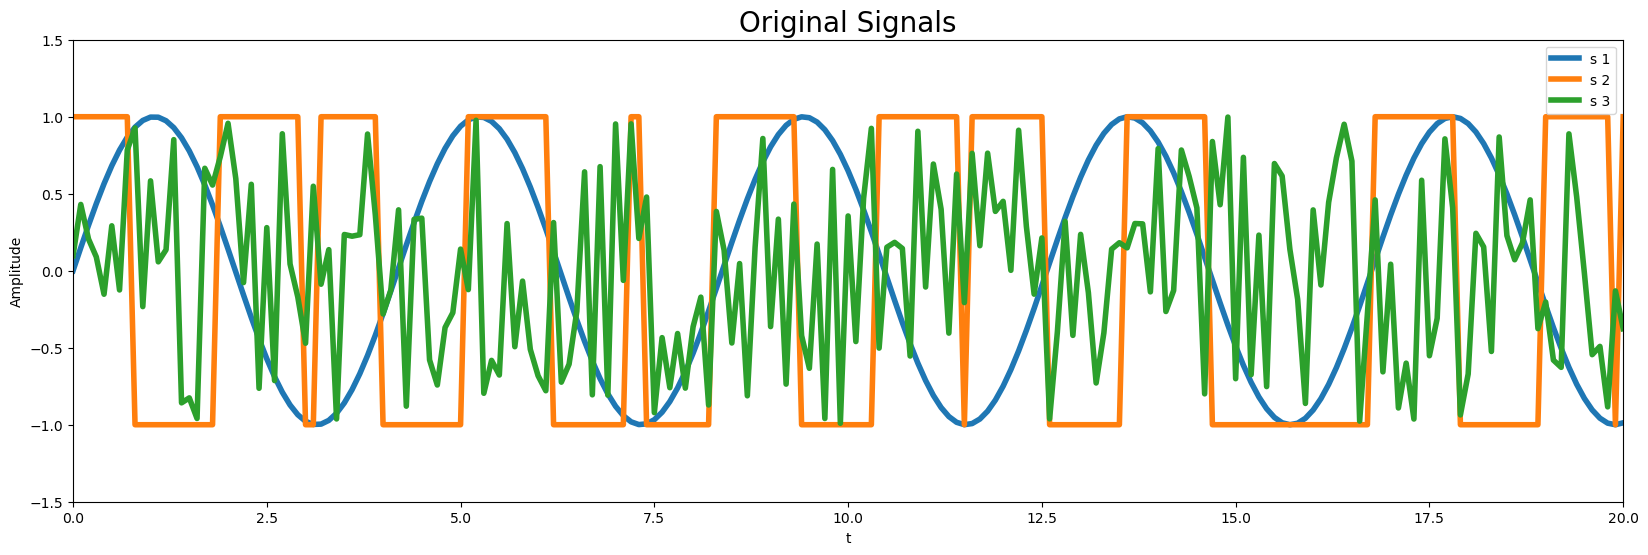

In [6]:
# Samples
n_samples = 10000
t = np.linspace(0, 1000, n_samples)

# Seed for reproducibility
np.random.seed(0)

# Generate 3 signals
s1 = np.sin(t*1.5)                                          # Sine wave                            
s2 = np.sign((np.cos(t*2.2) + np.sin(t*3.7)))           # Square wave
s3 = np.random.uniform(-1, 1, n_samples)                # Random uniform noise

# Sources matrix
S = np.array([s1, s2, s3])


# Plotting the signals
plot_signals(t, S, "Original Signals", labels = True, scaling = 1.5)

Here we build a mixing matrix and mix the signals

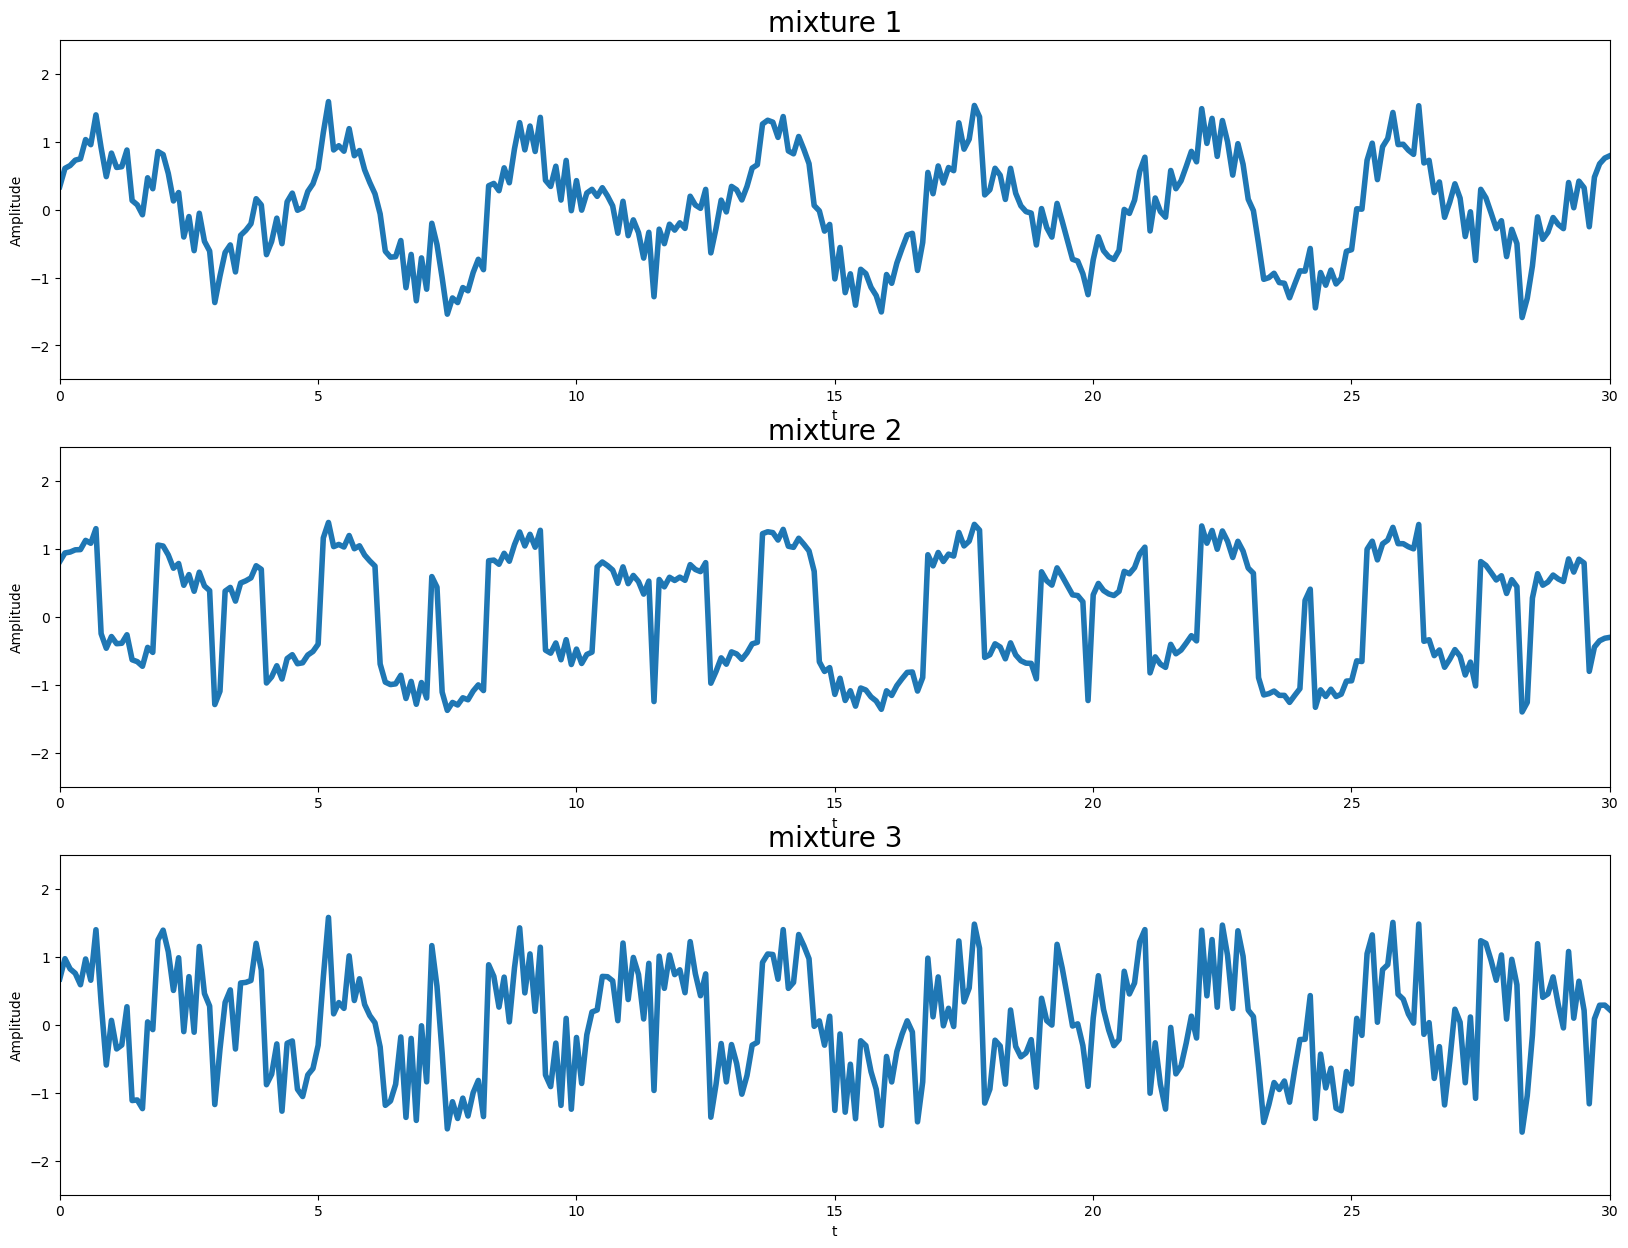

In [7]:
# # Mixing matrix
A = np.array([[0.9, 0.3, 0.4],
              [0.4, 0.8, 0.2],
              [0.2, 0.6, 0.8]])


# Mixed signals
X = A @ S

# Plotting the mixed signals
plot_mixtures(t, X, scaling = 2.5)

In [8]:
# Reconstructing the signals
S_recovered, W = FastIca(X, n_to_recover=3, n_sources=3)

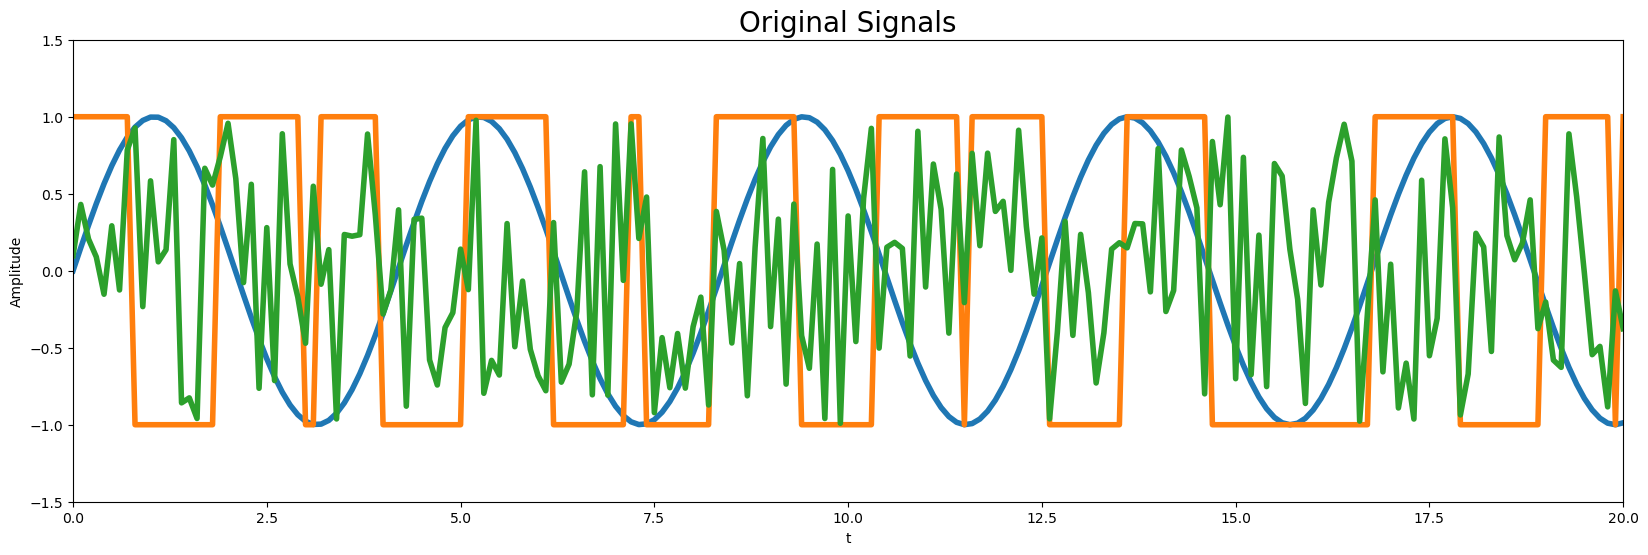

In [9]:
plot_signals(t, S, "Original Signals", labels = False, scaling = 1.5)

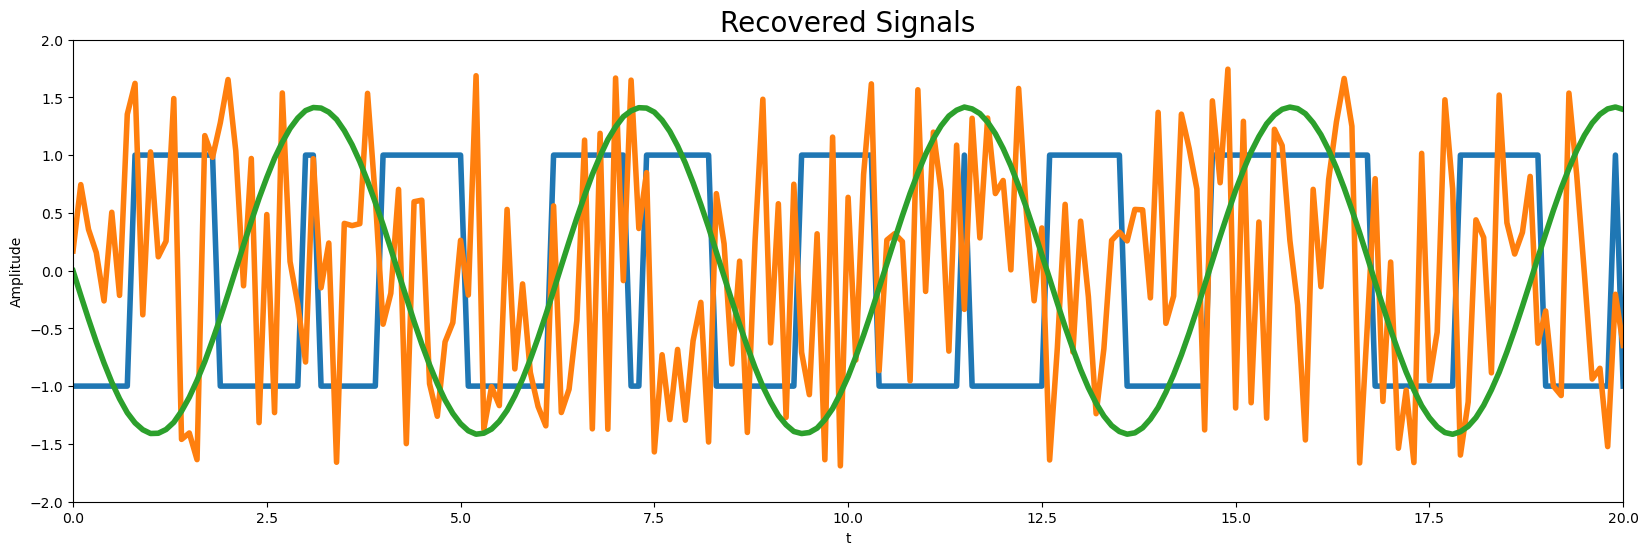

In [10]:
plot_signals(t, S_recovered, "Recovered Signals", labels = False, scaling = 2)

As we can see ICA recovers some of the original source signals with their **signs swapped**. This occurs because ICA aims to separate statistically independent sources, and the linear mixing process itself doesn't inherently preserve the signs of the original sources. In other words, multiplying a source signal by -1 doesn't affect its independence from other sources, nor does it alter the linear mixing process.  Therefore, ICA can recover the information content of the original sources, but the signs might be flipped in some cases.

The same holds for the **order** of the recovered source signals.

## Other Examples

### 4 Signals

In this example we see how the algorithm above behave when applied to a mixture of 4 signals

In [11]:
# Samples
n_samples = 10000                                      
t = np.linspace(0, 1000, n_samples)

# Generate 4 signals
s1 = np.sin(t*1.5)                                          # Sine wave                            
s2 = np.sign((np.cos(t*2.2) + np.sin(t*3.7)))           # Square wave
s3 = np.cos(t*0.7)                                      # Cosine
s4 = signal.sawtooth(t*2.1).squeeze()                   # Sawtooth wave  


# Sources matrix
S = np.array([s1, s2, s3, s4])


# # Mixing matrix
A = np.array([[0.9, 0.5, 0.4, 0.6],
              [0.4, 0.7, 0.2, 0.3],
              [0.2, 0.4, 0.8, 0.5],
              [0.3, 1, 0.2, 0.9]])


# Mixed signals
X = A @ S


# FastICA
S_recovered, W = FastIca(X, n_to_recover=4, n_sources=4)

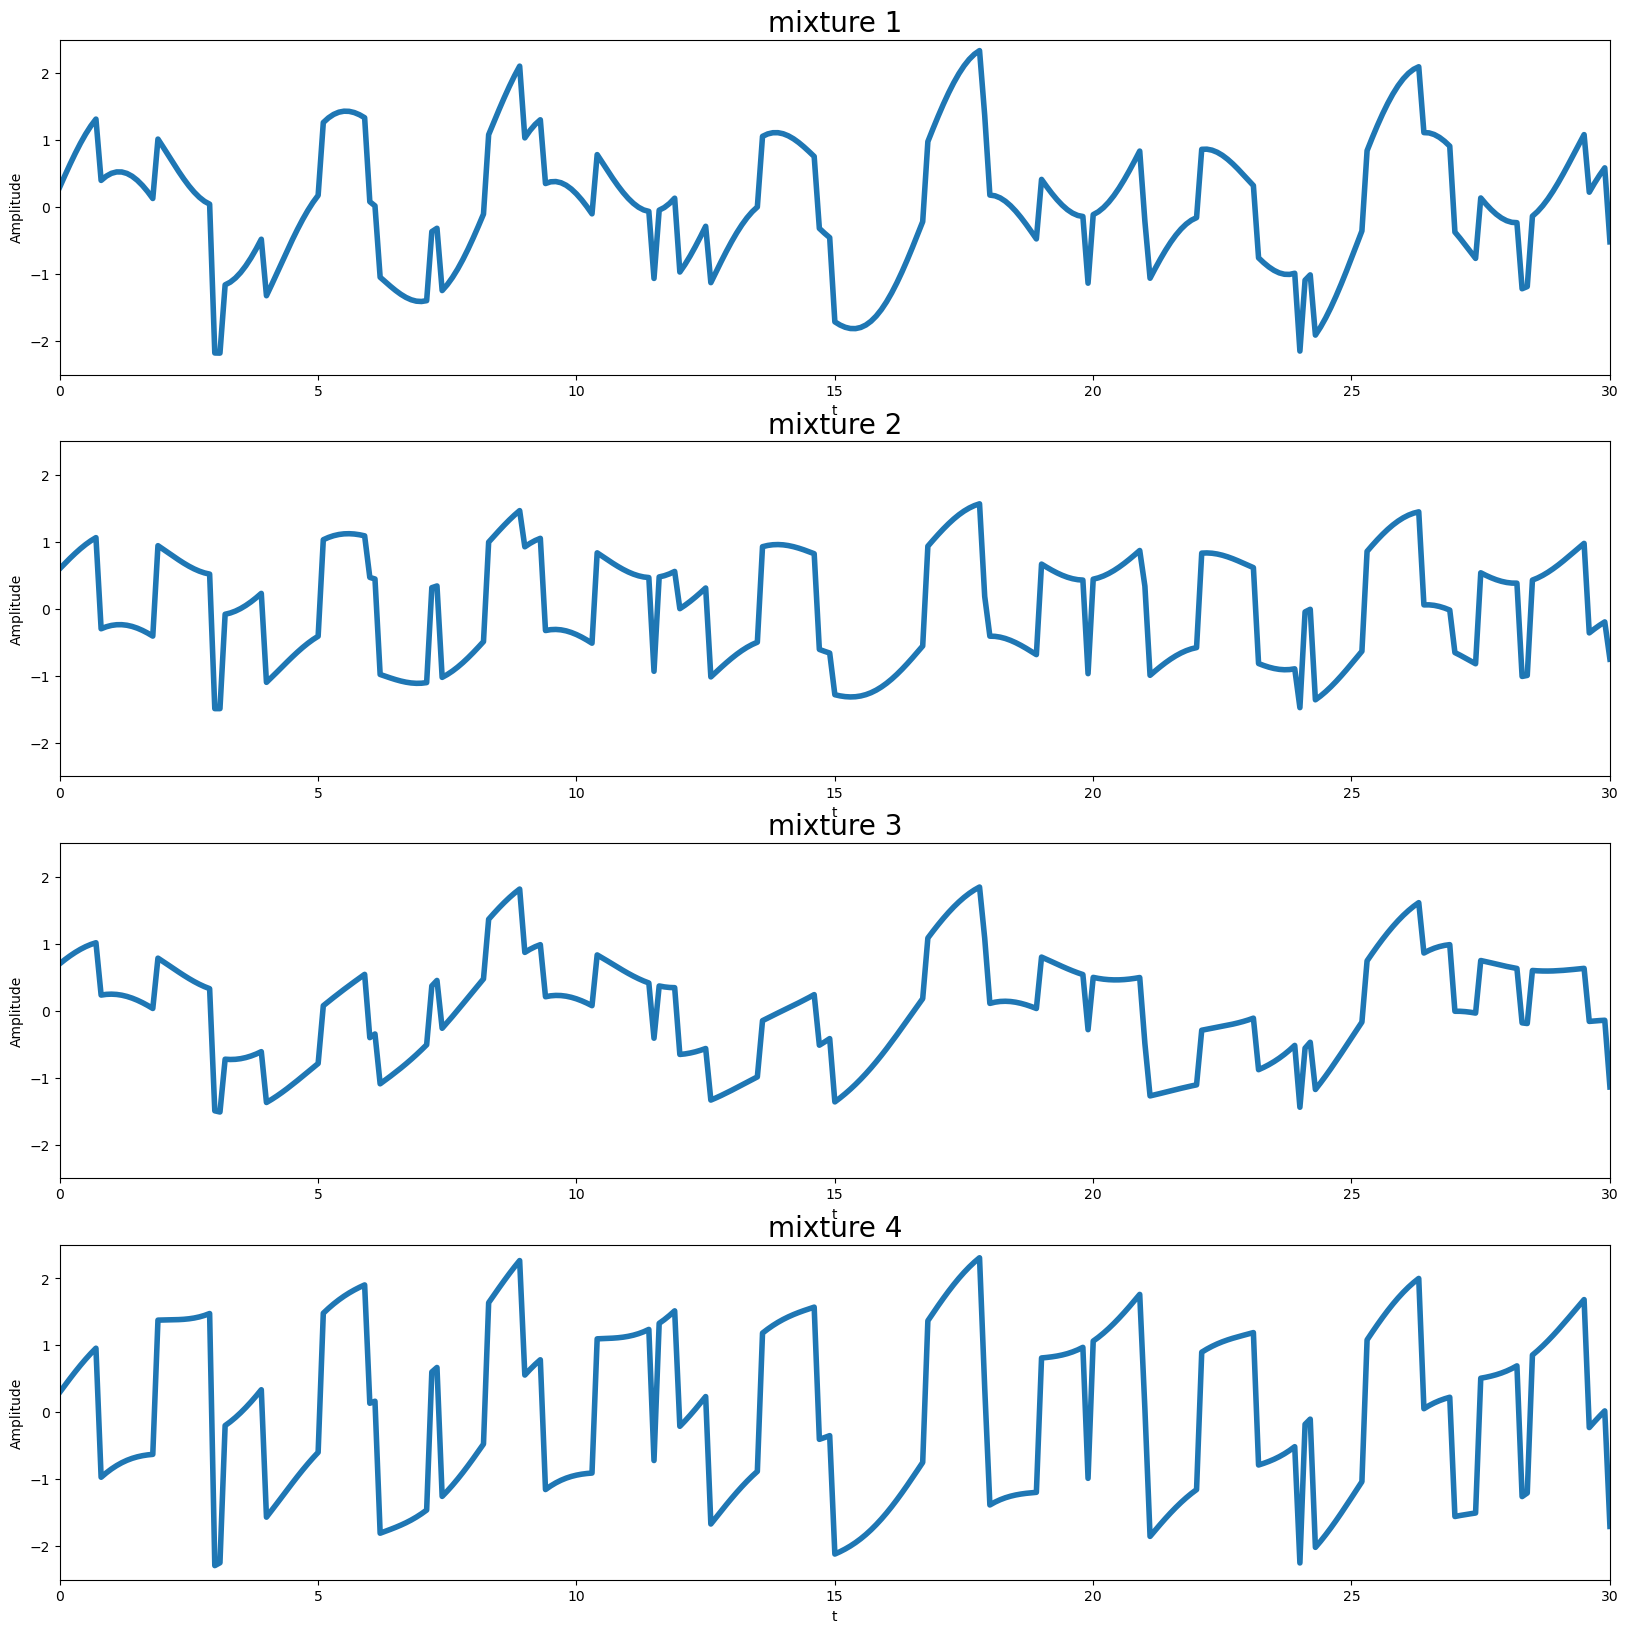

In [12]:
# Plotting the mixed signals
plot_mixtures(t, X, scaling = 2.5)

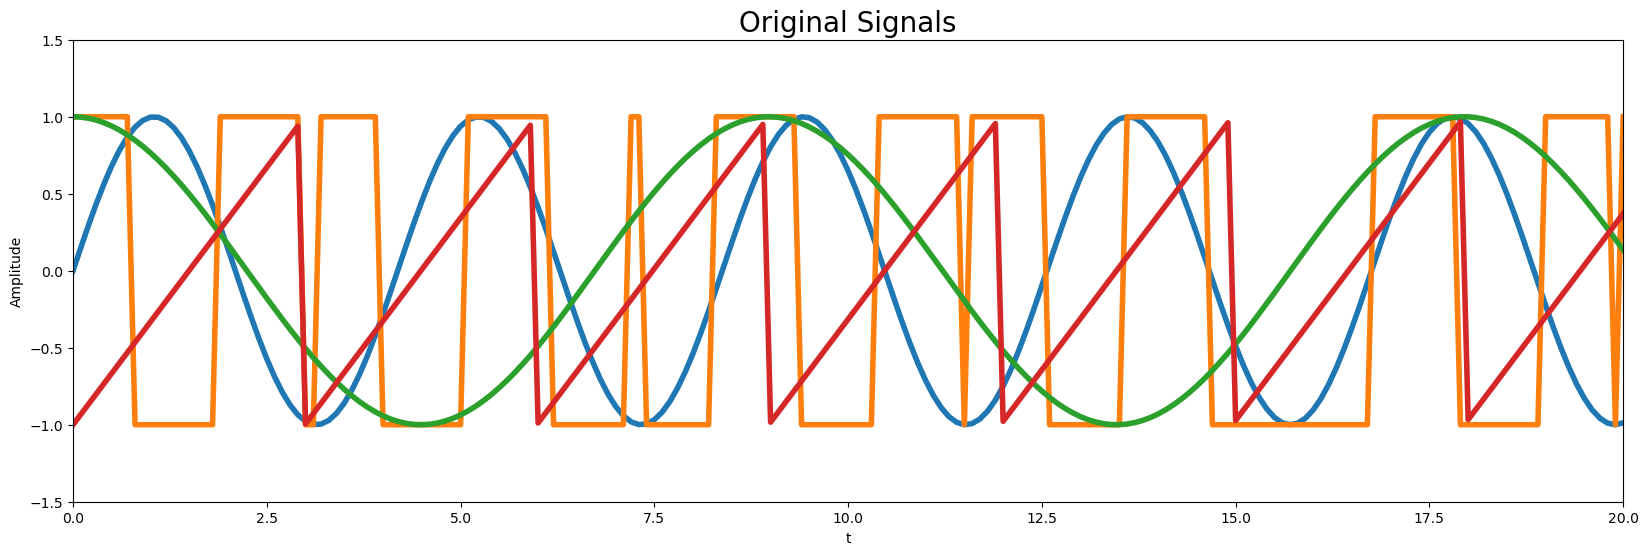

In [13]:
plot_signals(t, S, "Original Signals", labels = False, scaling = 1.5)

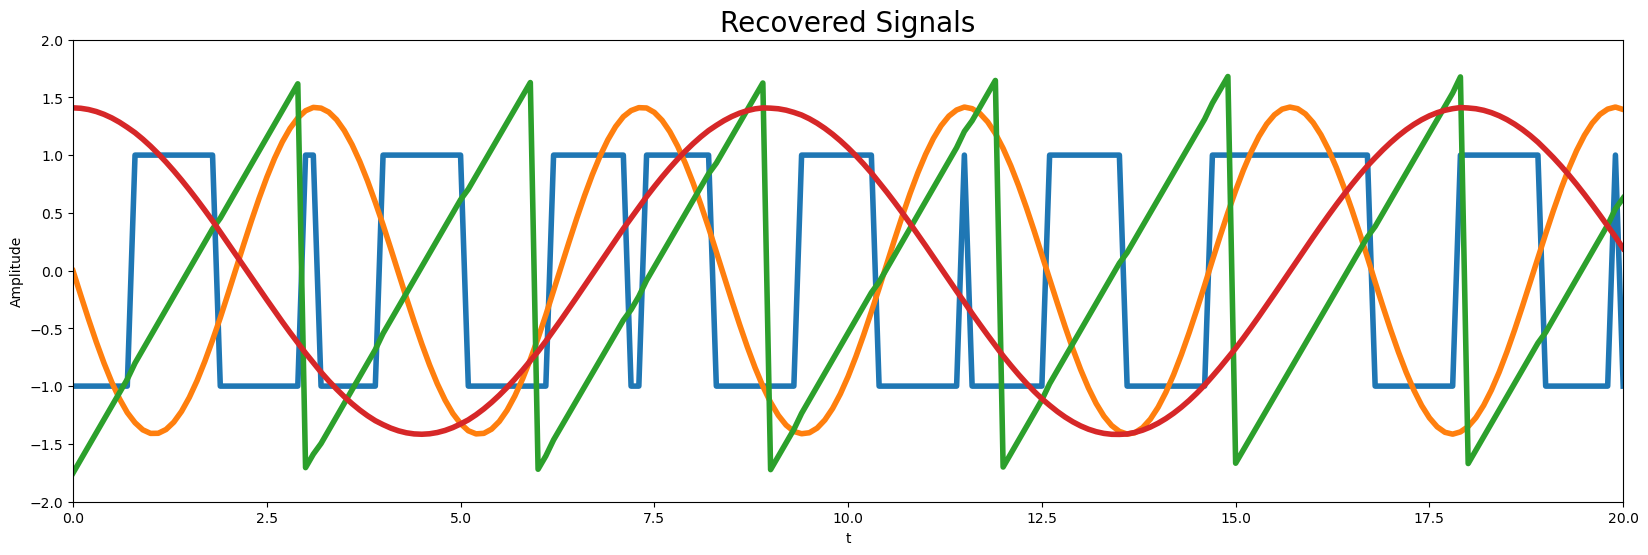

In [14]:
plot_signals(t, S_recovered, "Recovered Signals", labels = False, scaling = 2)

### Undercomplete ICA

In this example we see how dimensionality reduction affects the under complete case (i.e more mixtures then sources)

In [15]:
# Samples
n_samples = 10000
t = np.linspace(0, 1000, n_samples)

# Generate 4 signals
s1 = np.sin(t)                                          # Sine wave                            
s2 = np.sign((np.cos(t*2.2) + np.sin(t*3.7)))           # Square wave
s3 = signal.sawtooth(t*2.1).squeeze()                   # Sawtooth wave  


# Sources matrix
S = np.array([s1, s2, s3])


# # Mixing matrix
A = np.array([[0.9, 0.5, 0.4],
              [0.4, 0.7, 0.2],
              [0.2, 0.4, 0.8],
              [0.3, 1, 0.2]])


# Mixed signals
X = A @ S


# FastICA
S_recovered_undercomplete, W = FastIca(X, n_to_recover=3, n_sources=3, under_complete = True)
S_recovered, W = FastIca(X, n_to_recover=3, n_sources=3, under_complete = False)

Dimensionality reduction performed


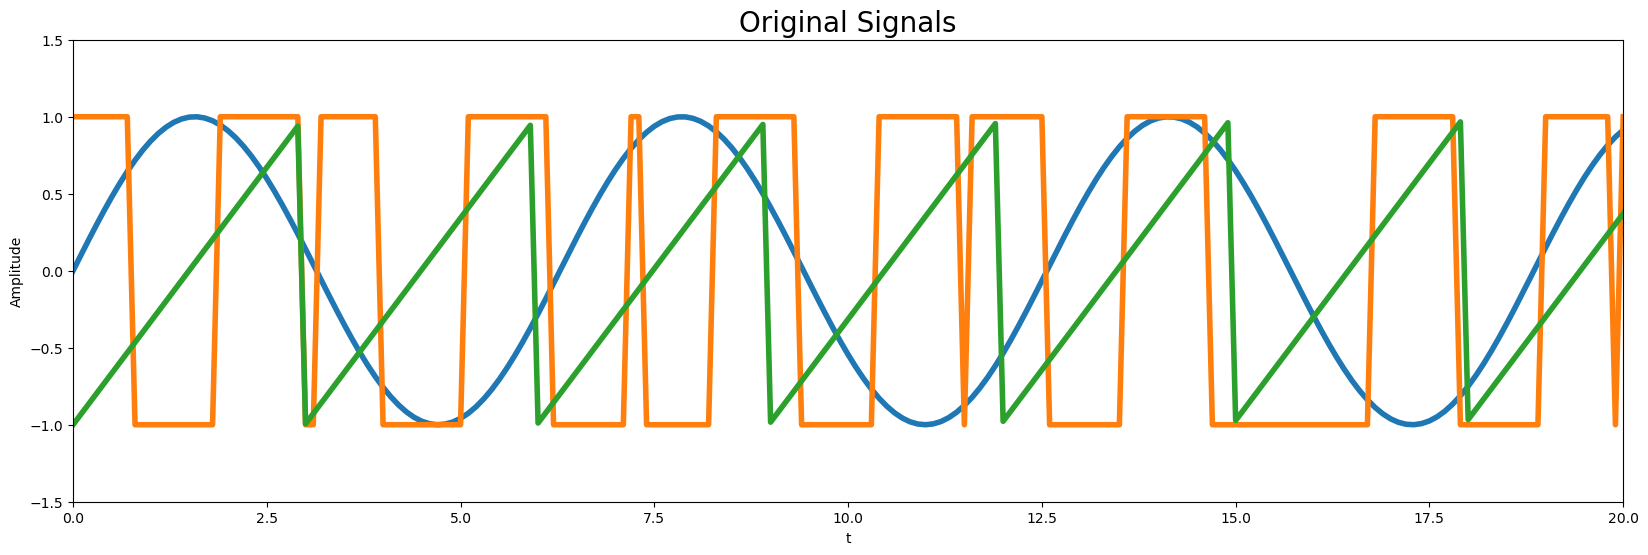

In [16]:
plot_signals(t, S, "Original Signals", labels = False, scaling = 1.5)

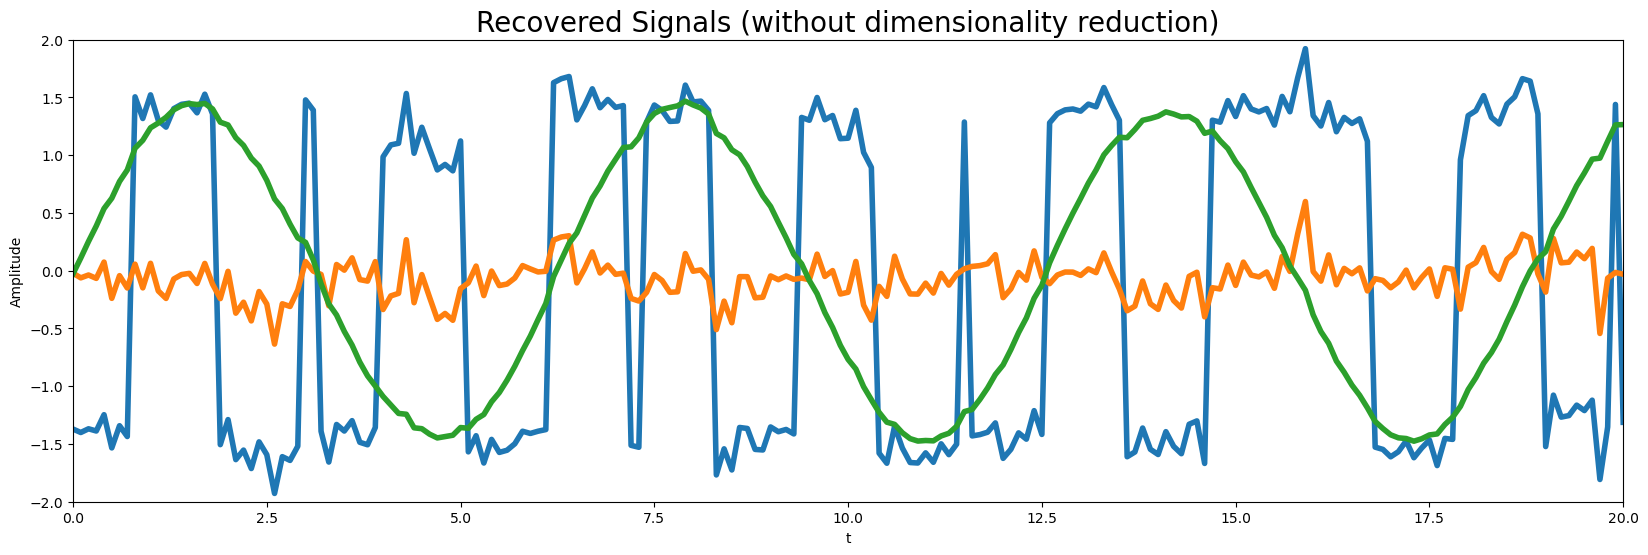

In [17]:
plot_signals(t, S_recovered, "Recovered Signals (without dimensionality reduction)", labels = False, scaling = 2)

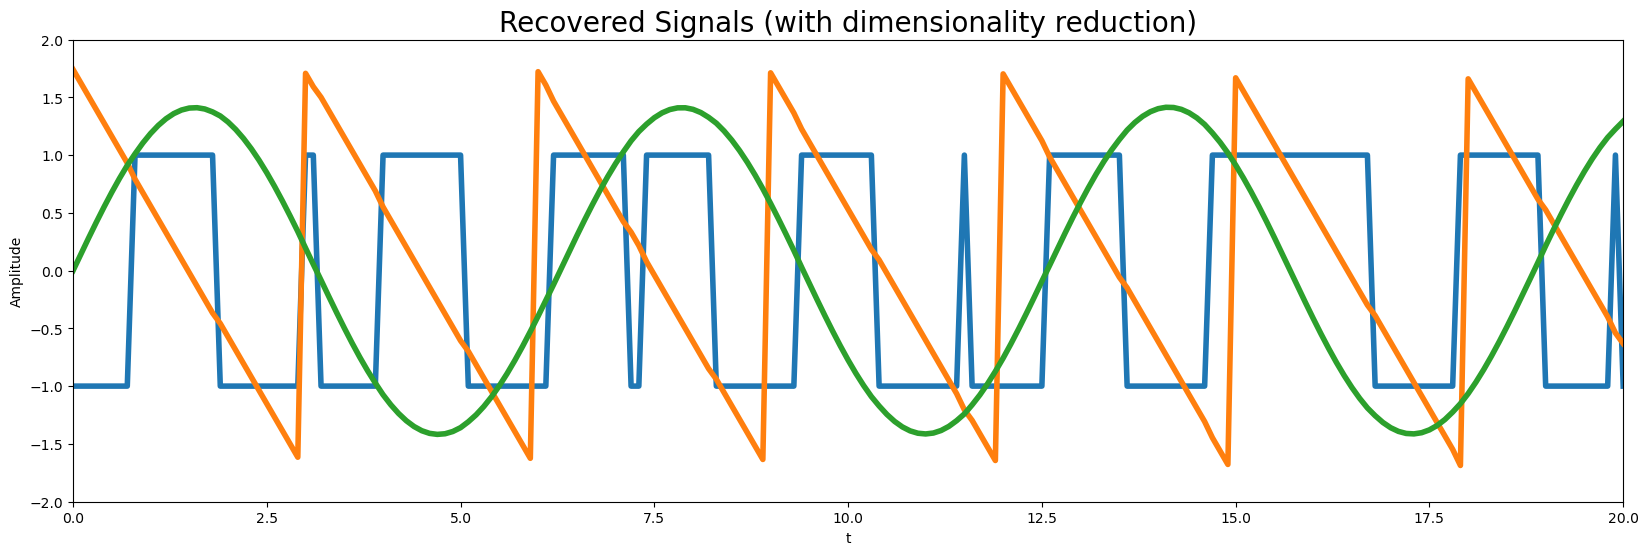

In [18]:
plot_signals(t, S_recovered_undercomplete, "Recovered Signals (with dimensionality reduction)", labels = False, scaling = 2)